In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from itertools import combinations
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.integrate import simpson

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from math import sqrt

# Latexify function with fallback fonts
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting."""
    assert(columns in [1,2])
    
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9  # width in inches
    
    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0
        fig_height = fig_width*golden_mean
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        fig_height = MAX_HEIGHT_INCHES
    
    params = {
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'font.size': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif'],
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 0.8,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    }
    
    matplotlib.rcParams.update(params)

### Preprocess steps

In [3]:
ground_truth_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
ground_truth_df.head()

,city,state,YearMonth,AT,BP,PM2.5,RF,VWS,WD,WS,latitude,longitude
0,Agartala,Tripura,2023-01,NaN,750.000000,196.040103,0.044160,NaN,195.440729,0.480669,23.81755,91.272697
1,Agartala,Tripura,2023-02,NaN,750.000000,170.874875,0.000263,NaN,245.936520,0.686900,23.81755,91.272697
2,Agartala,Tripura,2023-03,NaN,750.000000,119.490881,0.009865,NaN,190.550450,0.605829,23.81755,91.272697
3,Agartala,Tripura,2023-04,NaN,749.961354,94.205356,0.027917,NaN,205.834600,0.615330,23.81755,91.272697
4,Agartala,Tripura,2023-05,NaN,749.904747,63.553585,0.015649,NaN,212.567998,0.652385,23.81755,91.272697


In [4]:
gemma_9b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
# llama1_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_1_70b_it_2023_predictions.csv")
qwen_32b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
qwen_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_8b_2023_predictions.csv")
qwen_14b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_14b_2023_predictions.csv")
# mistral_7b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/mistral7b_instruct_2023_predictions.csv")
gpt_oss_20b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gptoss20b_2023_predictions.csv")
gpt_oss_120b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gptoss120b_2023_predictions.csv")
# deepseek_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/deepseek_V2_2023_predictions.csv")
gemini_flash_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemini_flash_2023.csv")
gpt_4o_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gpt_4o_pm25.csv")
claude_sonnet_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/claude_sonnet_2023.csv")
print(gemma_9b_df.columns)
print(gemma_27b_df.columns)
print(llama_8b_df.columns)
print(llama_70b_df.columns)
# print(llama1_70b_df.columns)
print(qwen_8b_df.columns)
print(qwen_14b_df.columns)
print(qwen_32b_df.columns)
# print(mistral_7b_df.columns)
print(gpt_oss_20b_df.columns)
print(gpt_oss_120b_df.columns)
# print(deepseek_df.columns)
print(gemini_flash_df.columns)
print(gpt_4o_df.columns)
print(claude_sonnet_df.columns)

Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')
Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')


In [4]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-9b-it,38.7
1,Agartala,Tripura,2023,February,google/gemma-2-9b-it,35.2
2,Agartala,Tripura,2023,March,google/gemma-2-9b-it,35.2
3,Agartala,Tripura,2023,April,google/gemma-2-9b-it,38.7
4,Agartala,Tripura,2023,May,google/gemma-2-9b-it,38.7


In [6]:
ground_truth_df['YearMonth'] = pd.to_datetime(ground_truth_df['YearMonth'])
ground_truth_df['year'] = ground_truth_df['YearMonth'].dt.year
ground_truth_df['month'] = ground_truth_df['YearMonth'].dt.strftime('%B')

ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

ground_truth_df = ground_truth_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [6]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


In [13]:
gemma_9b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-9b-it,38.7
1,Agartala,Tripura,2023,February,google/gemma-2-9b-it,35.2
2,Agartala,Tripura,2023,March,google/gemma-2-9b-it,35.2
3,Agartala,Tripura,2023,April,google/gemma-2-9b-it,38.7
4,Agartala,Tripura,2023,May,google/gemma-2-9b-it,38.7


### Do LLMs predict within the valid PM2.5 range (0–500 μg/m³)?

In [6]:
def check_valid_pm25_range_table_ignore_nan(dfs_with_names):
    results = []

    for df, model_name in dfs_with_names:
        df = df.copy()
        df['pm2.5'] = pd.to_numeric(df['pm2.5'], errors='coerce')

        df = df.dropna(subset=['pm2.5'])
        total = len(df)

        count_below_0 = (df['pm2.5'] < 0).sum()
        count_above_500 = (df['pm2.5'] > 500).sum()
        count_valid = df['pm2.5'].between(0, 500).sum()

        percent_valid = (count_valid / total) * 100
        percent_below_0 = (count_below_0 / total) * 100
        percent_above_500 = (count_above_500 / total) * 100

        valid_check = "Match" if (
            (percent_valid == 100) or (count_below_0 > 0 or count_above_500 > 0)
        ) else "Mismatch"

        results.append({
            "Model": model_name,
            "% (PM2.5 in 0-500)": f"{percent_valid:.2f}%",
            "% (PM2.5 < 0)": f"{percent_below_0:.2f}%",
            "% (PM2.5 > 500)": f"{percent_above_500:.2f}%",
        })

    result_df = pd.DataFrame(results)
    print(result_df)

check_valid_pm25_range_table_ignore_nan([
    (gemma_9b_df, "Gemma 2 - 9B"),
    (gemma_27b_df, "Gemma 2 - 27B"),
    (llama_8b_df, "LLaMA 3.1 - 8B"),
    # (llama3_70b_df , "LLaMA 3.1 - 70B"),
    (llama_70b_df, "LLaMA 3.3 - 70B"),
    (qwen_8b_df, "Qwen 3 - 8B"),
    (qwen_14b_df, "Qwen 3 - 14B"),
    (qwen_32b_df, "Qwen 3 - 32B"),
    # (mistral_7b_df, "Mistral - 7B"),
    (gpt_oss_20b_df,"GPT-OSS - 20B"),
    (gpt_oss_120b_df,"GPT-OSS - 120B"),
    (gemini_flash_df, "Gemini-2.5-Flash"),
    (gpt_4o_df,"GPT 4o"),
    (claude_sonnet_df, "Claude Sonnet - 4.5")
    # (deepseek_df, "Deepseek - V2")
])

                  Model % (PM2.5 in 0-500) % (PM2.5 < 0) % (PM2.5 > 500)
0          Gemma 2 - 9B            100.00%         0.00%           0.00%
1         Gemma 2 - 27B            100.00%         0.00%           0.00%
2        LLaMA 3.1 - 8B            100.00%         0.00%           0.00%
3       LLaMA 3.3 - 70B            100.00%         0.00%           0.00%
4           Qwen 3 - 8B            100.00%         0.00%           0.00%
5          Qwen 3 - 14B            100.00%         0.00%           0.00%
6          Qwen 3 - 32B            100.00%         0.00%           0.00%
7         GPT-OSS - 20B            100.00%         0.00%           0.00%
8        GPT-OSS - 120B            100.00%         0.00%           0.00%
9      Gemini-2.5-Flash            100.00%         0.00%           0.00%
10               GPT 4o            100.00%         0.00%           0.00%
11  Claude Sonnet - 4.5            100.00%         0.00%           0.00%


### Are predictions correlated with ground-truth CPCB data?

1. **Pearson Correlation Coefficient**

Measures linear correlation between predicted and actual values:

$$
\text{Pearson}(y, \hat{y}) = \frac{\sum_{i=1}^{n} (y_i - \bar{y})(\hat{y}_i - \bar{\hat{y}})}{\sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2} \sqrt{\sum_{i=1}^{n} (\hat{y}_i - \bar{\hat{y}})^2}}
$$

2. **Mean Absolute Error (MAE)**

Average of the absolute differences between actual and predicted values:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

In [1]:
import numpy as np

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05, random_state=0):
    """
    Generic non-parametric bootstrap CI for a scalar metric.
    metric_fn: function(y_true, y_pred) -> float
    Returns (lower, upper, std_boot).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    stats = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower, upper, stats.std(ddof=1)

In [7]:
def evaluate_model_against_ground_truth(model_df, model_name, n_bootstrap=1000):
    # Merge with ground truth
    model_df = model_df.copy()
    ground_df = ground_truth_df.copy()

    for df in [model_df, ground_df]:
        df['city_lower'] = df['city'].str.strip().str.lower()
        df['state_lower'] = df['state'].str.strip().str.lower()
        df['month_lower'] = df['month'].str.strip().str.lower()
        df['year'] = df['year'].astype(int)

    merged_df = pd.merge(
        model_df,
        ground_df,
        left_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        right_on=['city_lower', 'state_lower', 'year', 'month_lower'],
        how='inner'
    )

    y_true = merged_df['ground_truth_pm25']
    y_pred = merged_df['pm2.5']

    n_total = len(y_true)
    valid = (~y_true.isna()) & (~y_pred.isna())
    n_valid = valid.sum()
    y_true = y_true[valid].to_numpy()
    y_pred = y_pred[valid].to_numpy()
    n_nan = n_total - n_valid
    nan_percent = 100 * n_nan / n_total if n_total > 0 else 0

    # ------------------ base metrics ------------------
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Under and Over prediction
    under_mask = y_pred < y_true
    over_mask = y_pred > y_true
    equal_mask = y_pred == y_true

    total = len(y_true)
    percent_under = 100 * under_mask.sum() / total
    percent_over = 100 * over_mask.sum() / total
    percent_equal = 100 * equal_mask.sum() / total  # Optional

    mae_under = mean_absolute_error(y_true[under_mask], y_pred[under_mask]) if under_mask.any() else np.nan
    mae_over  = mean_absolute_error(y_true[over_mask],  y_pred[over_mask])  if over_mask.any()  else np.nan

    # ==================================================
    #  Uncertainty for MAE and Pearson
    #  1) SE
    #  2) Parametric CI from SE
    #  3) Bootstrap CI (non-parametric)
    # ==================================================
    if n_valid > 3:
        # ---------- MAE: SE + parametric CI ----------
        abs_errors = np.abs(y_pred - y_true)
        mae_se = abs_errors.std(ddof=1) / np.sqrt(n_valid)          # standard error of MAE (mean of |e|)
        mae_ci_low_param = mae - 1.96 * mae_se
        mae_ci_high_param = mae + 1.96 * mae_se

        # ---------- Pearson: SE (Fisher z) + parametric CI ----------
        # Fisher z-transform
        z = np.arctanh(np.clip(pearson_corr, -0.999999, 0.999999))
        pearson_se = 1.0 / np.sqrt(n_valid - 3)
        z_low = z - 1.96 * pearson_se
        z_high = z + 1.96 * pearson_se
        pearson_ci_low_param = np.tanh(z_low)
        pearson_ci_high_param = np.tanh(z_high)

        # ---------- Bootstrap CIs ----------
        if n_bootstrap and n_valid > 5:
            mae_ci_low_boot, mae_ci_high_boot, mae_std_boot = bootstrap_ci(
                lambda a, b: mean_absolute_error(a, b),
                y_true, y_pred, n_bootstrap=n_bootstrap
            )
            pearson_ci_low_boot, pearson_ci_high_boot, pearson_std_boot = bootstrap_ci(
                lambda a, b: pearsonr(a, b)[0],
                y_true, y_pred, n_bootstrap=n_bootstrap
            )
        else:
            mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
            pearson_ci_low_boot = pearson_ci_high_boot = pearson_std_boot = np.nan

    else:
        mae_se = mae_ci_low_param = mae_ci_high_param = np.nan
        pearson_se = pearson_ci_low_param = pearson_ci_high_param = np.nan
        mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
        pearson_ci_low_boot = pearson_ci_high_boot = pearson_std_boot = np.nan

    return {
        'model': model_name,
        'n_total': n_total,
        'n_valid': n_valid,
        'n_nan': n_nan,
        'pearson': pearson_corr,
        'spearman': spearman_corr,
        'mae': mae,
        'r2': r2,
        'under_percent': percent_under,
        'over_percent': percent_over,
        'mae_under': mae_under,
        'mae_over': mae_over,

        # ---- MAE uncertainty ----
        'mae_se': mae_se,
        'mae_ci_low_param': mae_ci_low_param,
        'mae_ci_high_param': mae_ci_high_param,
        'mae_ci_low_boot': mae_ci_low_boot,
        'mae_ci_high_boot': mae_ci_high_boot,
        'mae_std_boot': mae_std_boot,

        # ---- Pearson uncertainty ----
        'pearson_se': pearson_se,
        'pearson_ci_low_param': pearson_ci_low_param,
        'pearson_ci_high_param': pearson_ci_high_param,
        'pearson_ci_low_boot': pearson_ci_low_boot,
        'pearson_ci_high_boot': pearson_ci_high_boot,
        'pearson_std_boot': pearson_std_boot,
    }


In [8]:
results = []
results.append(evaluate_model_against_ground_truth(gemma_9b_df, "Gemma2-9B-it", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(gemma_27b_df, "Gemma2-27B-it", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(llama_8b_df, "LLaMA3.1-8B-Instruct", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(llama_70b_df, "LLaMA3.3-70B-Instruct", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(qwen_14b_df, "Qwen3-14B", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(qwen_32b_df, "Qwen3-32B", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(gpt_oss_20b_df,"GPT-OSS-20B", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(gpt_oss_120b_df,"GPT-OSS-120B", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(gemini_flash_df, "Gemini-2.5-Flash", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(gpt_4o_df,"GPT 4o", n_bootstrap=1000))
results.append(evaluate_model_against_ground_truth(claude_sonnet_df,"Claude Sonnet-4.5", n_bootstrap=1000))

results_df = pd.DataFrame(results)


In [25]:
display(results_df)

,model,n_total,n_valid,n_nan,pearson,spearman,mae,r2,under_percent,over_percent,...,mae_ci_high_param,mae_ci_low_boot,mae_ci_high_boot,mae_std_boot,pearson_se,pearson_ci_low_param,pearson_ci_high_param,pearson_ci_low_boot,pearson_ci_high_boot,pearson_std_boot
0,Gemma2-9B-it,2412,2397,15,0.245439,0.316159,27.326134,-0.161021,40.300375,59.699625,...,28.481986,26.211670,28.482076,0.582341,0.020438,0.207440,0.282698,0.204251,0.286736,0.021337
1,Gemma2-27B-it,2412,2412,0,0.578111,0.632667,34.724122,-0.282890,12.645108,87.354892,...,35.646716,33.821626,35.690682,0.462662,0.020374,0.550911,0.604085,0.546352,0.608639,0.015979
2,LLaMA3.1-8B-Instruct,2412,986,1426,0.248513,0.311148,37.608788,-0.836123,91.480730,8.519270,...,39.822140,35.460745,39.842592,1.116277,0.031895,0.189012,0.306195,0.201624,0.297511,0.024761
3,LLaMA3.3-70B-Instruct,2412,2412,0,0.548590,0.579094,46.701547,-1.436276,12.106136,87.893864,...,48.039364,45.352640,48.054205,0.694099,0.020374,0.520065,0.575893,0.518089,0.578298,0.015841
4,Qwen3-14B,2412,2412,0,0.387780,0.434571,39.132784,-0.749111,16.169154,83.830846,...,40.290322,38.066833,40.313567,0.585929,0.020374,0.353336,0.421173,0.349796,0.423111,0.018583
5,Qwen3-32B,2412,2412,0,0.469352,0.473264,28.213985,-0.239443,30.928690,69.071310,...,29.401480,27.032907,29.372674,0.601552,0.020374,0.437638,0.499900,0.427507,0.507970,0.020891
6,GPT-OSS-20B,2412,2412,0,0.131106,0.147892,30.179006,-0.473407,48.756219,51.243781,...,31.495413,28.970272,31.458300,0.643750,0.020374,0.091673,0.170128,0.080080,0.177818,0.024201
7,GPT-OSS-120B,2412,2412,0,0.143016,0.164796,39.402789,-1.031291,35.779436,64.220564,...,40.786955,38.113052,40.722982,0.688453,0.020374,0.103696,0.181890,0.100822,0.183779,0.021482
8,Gemini-2.5-Flash,2411,2375,36,0.647706,0.645501,26.478030,-0.257004,43.073684,56.926316,...,27.760283,25.199256,27.728844,0.655821,0.020533,0.623734,0.670462,0.617742,0.677852,0.015782
9,GPT 4o,2412,2381,31,0.512286,0.570749,27.497354,-0.249523,32.213356,67.786644,...,28.714272,26.345663,28.739648,0.609252,0.020507,0.482034,0.541317,0.473328,0.548495,0.019476


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def get_xerr(df, metric, err_type):
    """
    metric: 'mae' or 'pearson'
    err_type: 'se', 'param_ci', or 'boot_ci'
    Returns xerr suitable for bar / barh (can be 1D or 2xN for asymmetric).
    """
    if err_type == 'se':
        # symmetric ±1 SE
        col = f'{metric}_se'
        return df[col].to_numpy()

    elif err_type == 'param_ci':
        low = df[f'{metric}_ci_low_param'].to_numpy()
        high = df[f'{metric}_ci_high_param'].to_numpy()
        center = df[metric].to_numpy()
        lower = center - low
        upper = high - center
        return np.vstack([lower, upper])

    elif err_type == 'boot_ci':
        low = df[f'{metric}_ci_low_boot'].to_numpy()
        high = df[f'{metric}_ci_high_boot'].to_numpy()
        center = df[metric].to_numpy()
        lower = center - low
        upper = high - center
        return np.vstack([lower, upper])

    else:
        raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")

In [10]:
def plot_llm_performance(results_df, err_type="boot_ci", title_suffix="", save_path=None):
    df = results_df.copy()

    # keep the order in the dataframe (or sort if you want)
    model_names = df["model"].to_numpy()
    y = np.arange(len(df))

    pearson = df["pearson"].to_numpy()
    mae = df["mae"].to_numpy()

    xerr_pearson = get_xerr(df, "pearson", err_type)
    xerr_mae = get_xerr(df, "mae", err_type)

    # figsize comes from latexify() via rcParams
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # ---------------- Left panel: Pearson ----------------
    bar_color_left = "#4C6A92"
    ax1.barh(
        y,
        pearson,
        xerr=xerr_pearson,
        capsize=3,
        height=0.6,
        color=bar_color_left,
        edgecolor="none",
    )
    ax1.set_xlabel("Pearson Correlation")
    ax1.set_ylabel("Model")
    ax1.invert_yaxis()
    ax1.set_xlim(0.0, 1.0)
    ax1.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.3)
    ax1.set_axisbelow(True)

    # ---------------- Right panel: MAE ----------------
    bar_color_right = "#C45A5A"
    ax2.barh(
        y,
        mae,
        xerr=xerr_mae,
        capsize=3,
        height=0.6,
        color=bar_color_right,
        edgecolor="none",
    )
    ax2.set_xlabel("MAE (µg/m³)")

    # choose MAE x-limit from the CI you’re using
    if err_type == "boot_ci":
        mae_max = np.nanmax(df["mae_ci_high_boot"])
    else:
        mae_max = np.nanmax(df["mae_ci_high_param"])
    upper_lim = np.ceil(mae_max / 10.0) * 10.0
    ax2.set_xlim(0.0, upper_lim)

    ax2.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.3)
    ax2.set_axisbelow(True)

    # -------- Shared y-axis: model names on BOTH panels --------
    for ax in (ax1, ax2):
        ax.set_yticks(y)
        ax.set_yticklabels(model_names)
        ax.tick_params(axis="y", pad=4)

    # -------- Panel labels (a), (b) above each axis --------
    ax1.text(
        -0.9, 1.04, "(a)",
        transform=ax1.transAxes,
        fontsize=10,
        fontweight="bold",
        va="bottom",
        ha="left",
        clip_on=False,
    )

    ax2.text(
        -0.9, 1.04, "(b)",
        transform=ax2.transAxes,
        fontsize=10,
        fontweight="bold",
        va="bottom",
        ha="left",
        clip_on=False,
    )

    # remove top/right spines
    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    
    ax2.tick_params(axis="y", labelleft=True)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=300,
            format="pdf",
            bbox_inches="tight",
        )

    plt.show()

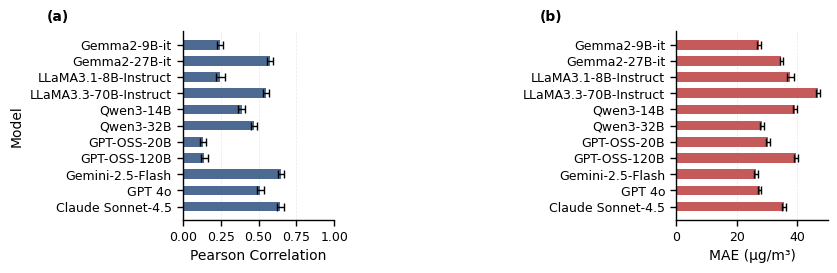

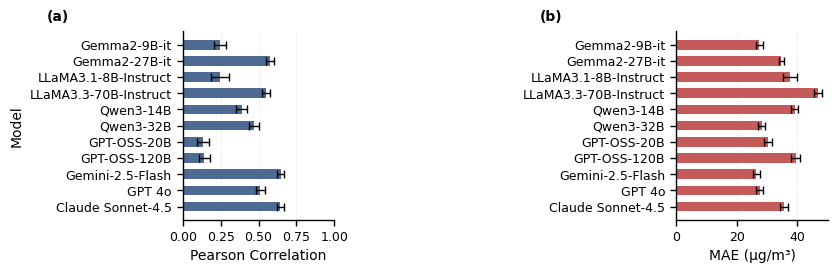

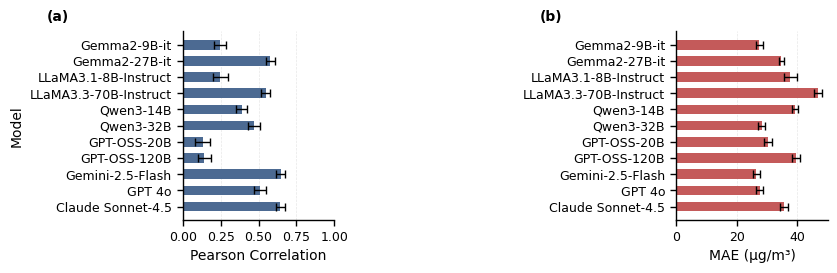

In [16]:
latexify(fig_width=10,fig_height=3,columns=2)

# 1) Using SE
plot_llm_performance(results_df, err_type='se', title_suffix=" (SE)", save_path="zero_shot_r_mae_se.pdf")

# 2) Using parametric CI (normal / Fisher z)
plot_llm_performance(results_df, err_type='param_ci', title_suffix=" (Parametric 95% CI)", save_path="zero_shot_r_mae_CI.pdf")

# 3) Using bootstrap CI
plot_llm_performance(results_df, err_type='boot_ci', title_suffix=" (Bootstrap 95% CI)", save_path="zero_shot_r_mae_boot_CI.pdf")

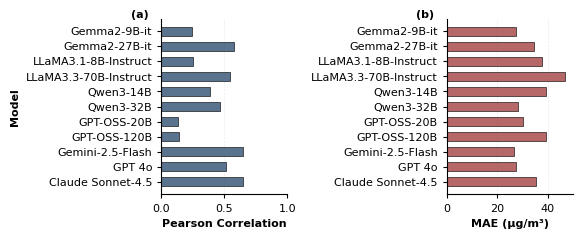

In [34]:
latexify(columns=2, fig_height=2.5)

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

color1 = '#3D5A7B'
color2 = '#A94E4E'

models = results_df['model'].values
y = np.arange(len(models))
height = 0.6  # bar thickness

# ----- (a) Pearson: horizontal bars -----
pearson = results_df['pearson'].values
axes[0].barh(
    y, pearson,
    height=height,
    color=color1,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
)
axes[0].set_xlabel('Pearson Correlation', fontsize=8, fontweight='bold')
axes[0].set_ylabel('Model', fontsize=8, fontweight='bold')
axes[0].set_yticks(y)
axes[0].set_yticklabels(models, fontsize=7)
axes[0].set_xlim(0, 1.0)
axes[0].grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.5)
axes[0].invert_yaxis()  # best model at top

axes[0].text(
    -0.10, 1.05, '(a)',
    transform=axes[0].transAxes,
    fontsize=8, fontweight='bold',
    va='top', ha='right'
)

# ----- (b) MAE: horizontal bars -----
mae = results_df['mae'].values
axes[1].barh(
    y, mae,
    height=height,
    color=color2,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
)
axes[1].set_xlabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
axes[1].set_yticks(y)
axes[1].set_yticklabels(models, fontsize=7)
y_max = int(np.ceil(mae.max() / 10) * 10)
axes[1].set_xlim(0, y_max)
axes[1].grid(axis='x', alpha=0.25, linestyle='--', linewidth=0.5)
axes[1].invert_yaxis()

axes[1].text(
    -0.10, 1.05, '(b)',
    transform=axes[1].transAxes,
    fontsize=8, fontweight='bold',
    va='top', ha='right'
)

# ----- common styling -----
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.tick_params(labelsize=8, width=0.8, length=3)
    ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('figure1.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

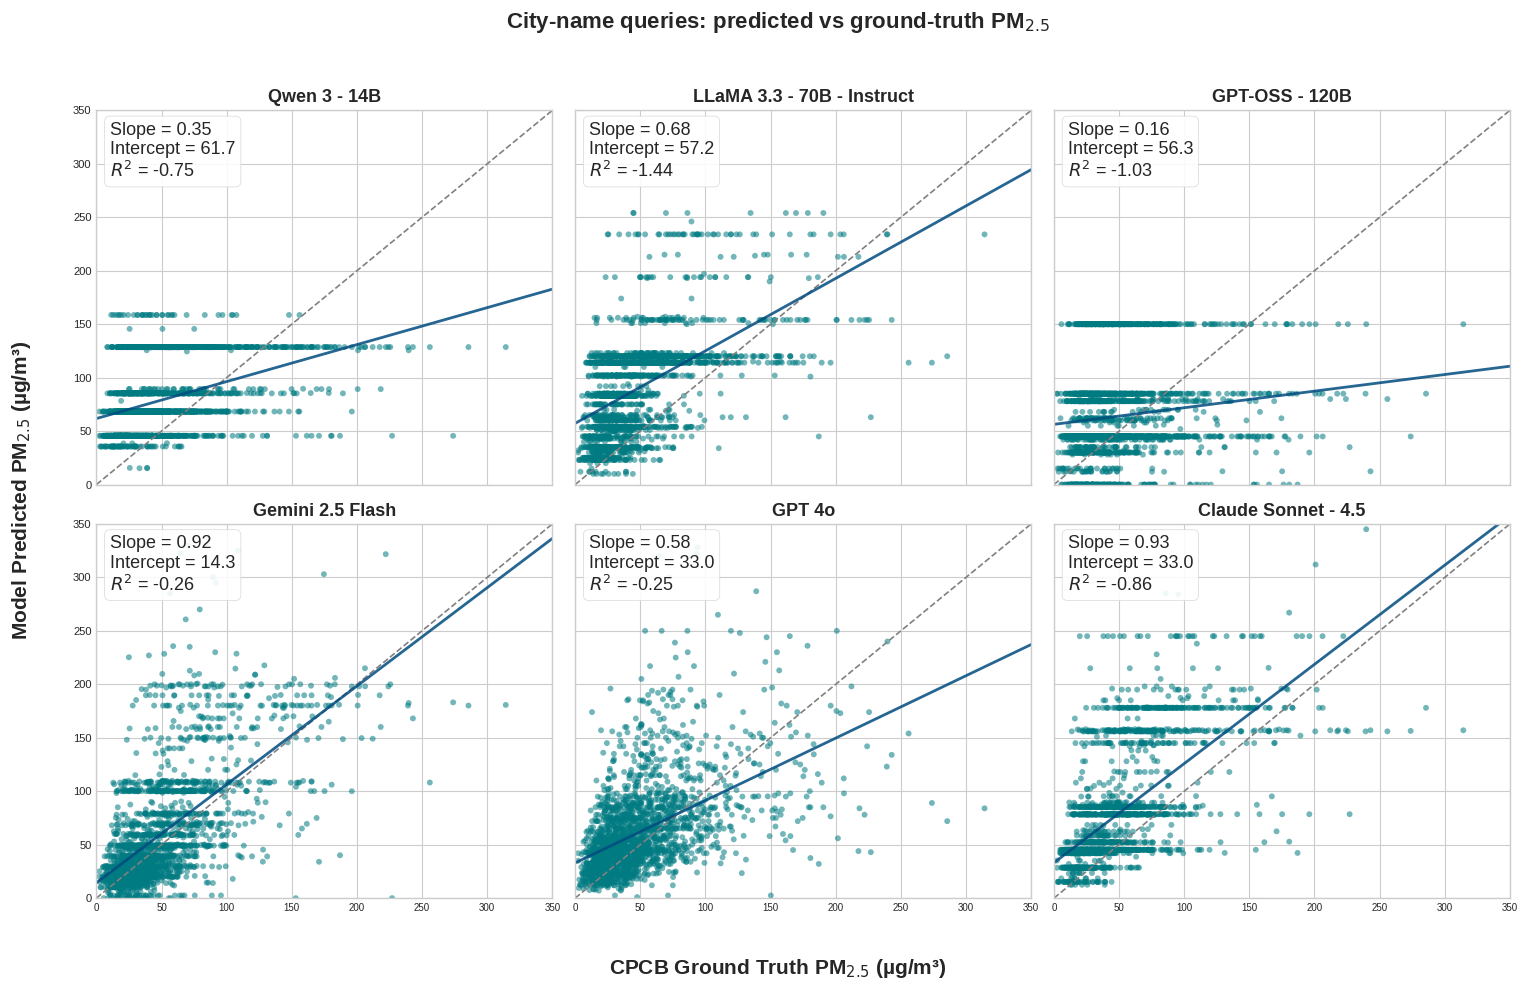

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

plt.style.use("seaborn-v0_8-whitegrid")  # clean base style

# ------------------------------------------------------------------
# Helper: merge model with ground truth
# ------------------------------------------------------------------
def merge_with_ground_truth(model_df, ground_df):
    model_df = model_df.copy()
    ground_df = ground_df.copy()

    for df in [model_df, ground_df]:
        df["city_lower"] = df["city"].str.strip().str.lower()
        df["state_lower"] = df["state"].str.strip().str.lower()
        df["month_lower"] = df["month"].str.strip().str.lower()
        df["year"] = df["year"].astype(int)

    merged_df = pd.merge(
        model_df,
        ground_df,
        left_on=["city_lower", "state_lower", "year", "month_lower"],
        right_on=["city_lower", "state_lower", "year", "month_lower"],
        how="inner",
    )

    y_true = merged_df["ground_truth_pm25"]
    y_pred = merged_df["pm2.5"]

    valid = (~y_true.isna()) & (~y_pred.isna())
    y_true = y_true[valid].to_numpy()
    y_pred = y_pred[valid].to_numpy()

    return y_true, y_pred

# ------------------------------------------------------------------
# Choose 6 models to display (you can change this list)
# ------------------------------------------------------------------
model_data = [
    # (gemma_9b_df,       "Gemma 2 - 9B - it"),
    (qwen_14b_df,       "Qwen 3 - 14B"),
    (llama_70b_df,      "LLaMA 3.3 - 70B - Instruct"),
    (gpt_oss_120b_df,   "GPT-OSS - 120B"),
    (gemini_flash_df,   "Gemini 2.5 Flash"),
    (gpt_4o_df,         "GPT 4o"),
    # you can swap in Claude if you like:
    (claude_sonnet_df, "Claude Sonnet - 4.5"),
]

# Optional: map model_name -> r2 from your results_df
r2_lookup = dict(zip(results_df["model"], results_df["r2"]))

# Axes limits
x_min, x_max = 0, 350
y_min, y_max = 0, 350

fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (model_df, model_name) in zip(axes, model_data):
    y_true, y_pred = merge_with_ground_truth(model_df, ground_truth_df)

    # Scatter
    ax.scatter(
        y_true,
        y_pred,
        c="#007b82",
        alpha=0.55,
        s=18,
        edgecolor="none"
    )

    # Ideal 1:1 line
    ax.plot(
        [x_min, x_max],
        [y_min, y_max],
        linestyle="--",
        color="grey",
        linewidth=1.2,
        label="Ideal"
    )

    if len(y_true) > 1:
        # Fit y_pred = a * y_true + b
        a, b = np.polyfit(y_true, y_pred, 1)

        # Regression line
        ax.plot(
            [x_min, x_max],
            [a * x_min + b, a * x_max + b],
            color="#004b7f",
            linewidth=2,
            alpha=0.85,
            label="Fit"
        )

        # R² against ground truth (consistent with results_df)
        r2 = r2_score(y_true, y_pred)

        # If you want to use exactly the table value (to avoid tiny discrepancies):
        if model_name in r2_lookup:
            r2 = r2_lookup[model_name]

        textstr = (
            f"Slope = {a:.2f}\n"
            f"Intercept = {b:.1f}\n"
            f"$R^2$ = {r2:.2f}"
        )

        ax.text(
            0.03,
            0.97,
            textstr,
            transform=ax.transAxes,
            fontsize=13,
            va="top",
            ha="left",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor="lightgrey",
                alpha=0.9
            ),
        )

    ax.set_title(model_name, fontsize=13, fontweight="bold")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Remove unused axes if fewer than 6 models
for ax in axes[len(model_data):]:
    fig.delaxes(ax)

fig.supxlabel("CPCB Ground Truth PM$_{2.5}$ (µg/m³)", fontsize=15, fontweight="bold")
fig.supylabel("Model Predicted PM$_{2.5}$ (µg/m³)", fontsize=15, fontweight="bold")

fig.suptitle(
    "City-name queries: predicted vs ground-truth PM$_{2.5}$",
    fontsize=16,
    fontweight="bold",
    y=0.98
)

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()

### Can models capture national and city-level seasonal pollution trends?

Total merged records: 14471
Unique cities: 200
Unique models: 6


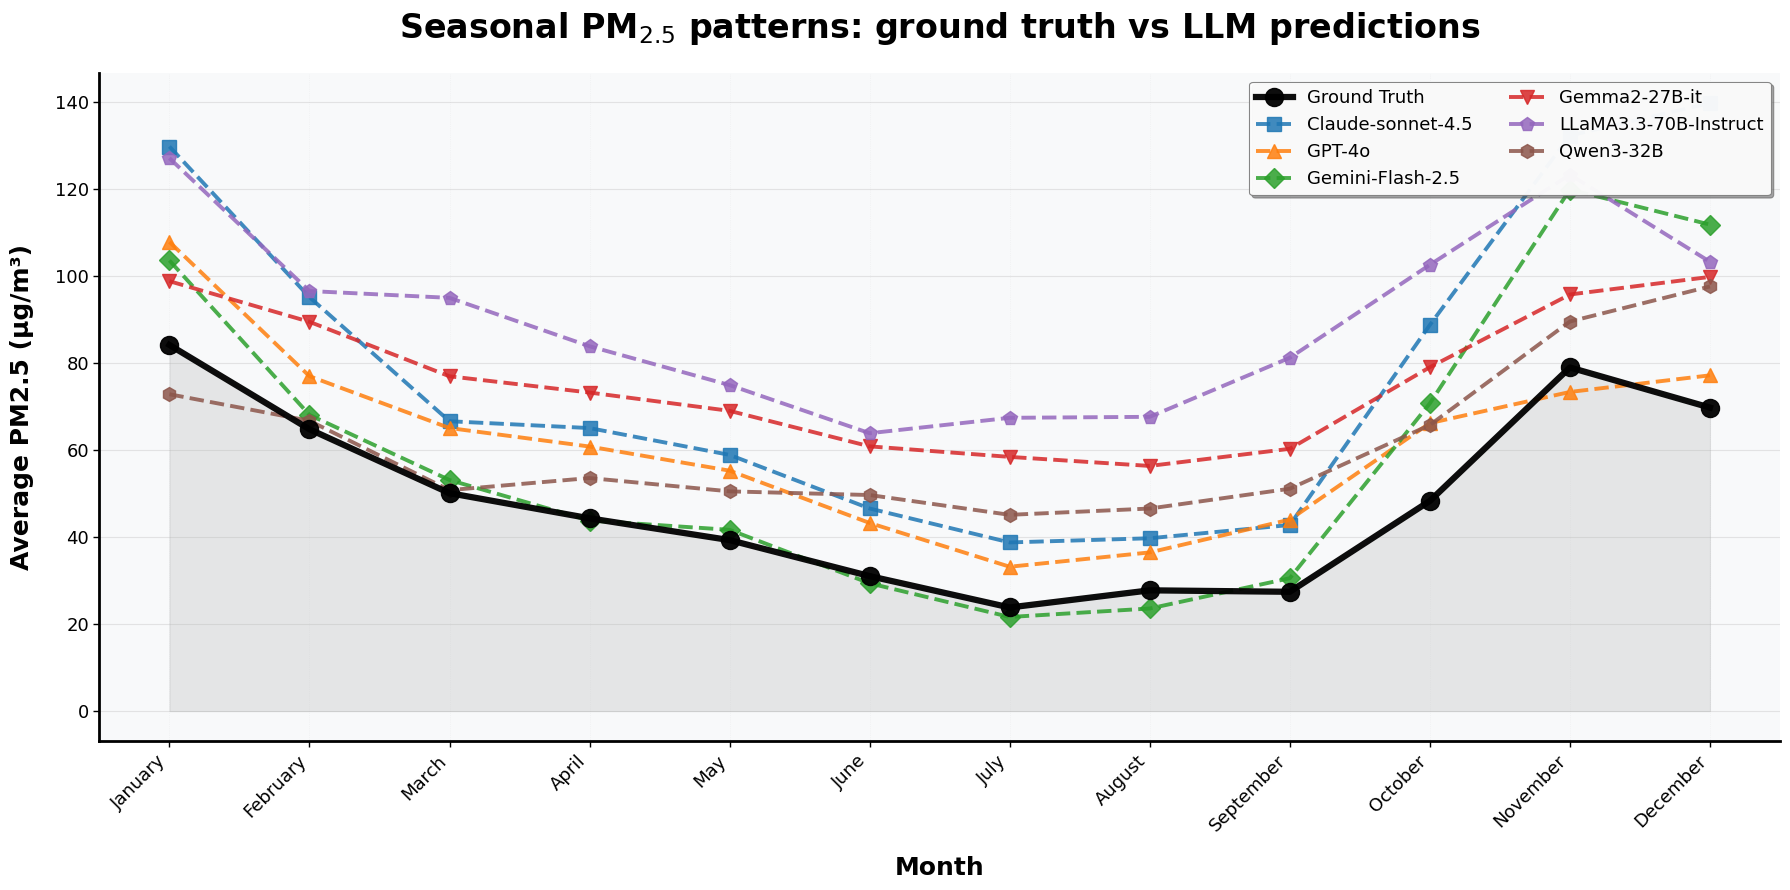

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Combine all models with simple names
model_dfs = {
    # "Gemma-2-9B": gemma_9b_df,
    "Gemma2-27B-it": gemma_27b_df,
    # "LLaMA-3.1-8B": llama_8b_df,
    "LLaMA3.3-70B-Instruct": llama_70b_df,
    # "Qwen-3-14B": qwen_14b_df,
    "Qwen3-32B": qwen_32b_df,
    # "GPT-OSS-20B": gpt_oss_20b_df,
    # "GPT-OSS-120B" : gpt_oss_120b_df,
    "Gemini-Flash-2.5": gemini_flash_df,
    "GPT-4o": gpt_4o_df,
    "Claude-sonnet-4.5": claude_sonnet_df
}

# Combine all models into one dataframe
all_models = []
for model_name, df in model_dfs.items():
    df = df.copy()
    df['model_name'] = model_name
    all_models.append(df)

combined_models = pd.concat(all_models, ignore_index=True)

# Merge with ground truth
merged_df = pd.merge(
    combined_models,
    ground_truth_df,
    on=['city', 'state', 'year', 'month'],
    how='inner'
)

print(f"Total merged records: {len(merged_df)}")
print(f"Unique cities: {merged_df['city'].nunique()}")
print(f"Unique models: {merged_df['model_name'].nunique()}")

# ============== IMPROVED LINE PLOT ==============

# Month ordering
month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']

# Calculate monthly averages
gt_monthly = ground_truth_df.groupby('month')['ground_truth_pm25'].mean().reindex(month_order)
model_monthly = merged_df.groupby(['model_name', 'month'])['pm2.5'].mean().unstack(fill_value=0)
model_monthly = model_monthly.reindex(columns=month_order)

# Create improved line plot
fig, ax = plt.subplots(figsize=(18, 9), facecolor='white')
ax.set_facecolor('#f8f9fa')

x = np.arange(len(month_order))

# Plot ground truth with emphasis
ax.plot(x, gt_monthly.values, marker='o', linewidth=4.5, markersize=13,
        label='Ground Truth', color='black', linestyle='-', zorder=10, alpha=0.95)

# Fill area under ground truth
ax.fill_between(x, 0, gt_monthly.values, alpha=0.08, color='black', zorder=1)

# Plot models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markers = ['s', '^', 'D', 'v', 'p', 'h']

for i, model_name in enumerate(model_monthly.index):
    ax.plot(x, model_monthly.loc[model_name].values, marker=markers[i], linewidth=2.8,
            markersize=10, label=model_name, color=colors[i], alpha=0.85, linestyle='--')

# Title and labels
ax.set_title('Seasonal PM$_{2.5}$ patterns: ground truth vs LLM predictions', 
             fontsize=24, fontweight='bold', pad=25)
ax.set_ylabel('Average PM2.5 (µg/m³)', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Month', fontsize=18, fontweight='bold', labelpad=15)

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(month_order, rotation=45, ha='right', fontsize=13)
ax.set_xlim(-0.5, len(month_order) - 0.5)

# Legend
ax.legend(fontsize=13, frameon=True, loc='upper right', 
          framealpha=0.95, edgecolor='gray', shadow=True, ncol=2)

# Grid
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.15, linestyle=':', linewidth=0.5)

# Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=13)

plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Month ordering
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Model dataframes (as you defined them)
model_dfs = {
    "Gemma2-9B-it":      gemma_9b_df,
    "Gemma2-27B-it":     gemma_27b_df,
    # "LLaMA-3.1-8B":       llama_8b_df,
    "LLaMA3.3-70B-Instruct":      llama_70b_df,
    "Qwen3-8B":          qwen_8b_df,
    "Qwen3-14B":         qwen_14b_df,
    "Qwen3-32B":         qwen_32b_df,
    "GPT-OSS-20B":        gpt_oss_20b_df,
    "GPT-OSS-120B":       gpt_oss_120b_df,
    "Gemini-2.5-Flash":   gemini_flash_df,
    "GPT-4o":             gpt_4o_df,
    "Claude-Sonnet-4.5":  claude_sonnet_df
}

ground = ground_truth_df.copy()

def compute_city_seasonality(model_df):
    df = model_df.copy()

    # Merge model predictions with ground truth
    merged = pd.merge(
        df,
        ground,
        on=["city", "state", "year", "month"],
        how="inner"
    )

    city_corrs = []

    # Group by city
    for city, g in merged.groupby("city"):
        # Average over any duplicates: city-month might have multiple rows
        g_month = (
            g.groupby("month")[["pm2.5", "ground_truth_pm25"]]
             .mean()
             .reindex(month_order)
        )

        g_month = g_month.dropna()
        if len(g_month) >= 8:  # need enough months
            gt = g_month["ground_truth_pm25"].values
            pred = g_month["pm2.5"].values
            if np.std(gt) > 0 and np.std(pred) > 0:
                r = np.corrcoef(gt, pred)[0, 1]
                city_corrs.append(r)

    return np.array(city_corrs)

# Compute percentage of cities with good seasonal pattern for each model
threshold = 0.5
seasonal_stats = []

for name, df in model_dfs.items():
    city_corrs = compute_city_seasonality(df)
    n_cities = len(city_corrs)
    if n_cities == 0:
        pct_good = 0.0
    else:
        pct_good = 100.0 * np.sum(city_corrs >= threshold) / n_cities

    seasonal_stats.append({
        "model": name,
        "n_cities": n_cities,
        "pct_cities_good": pct_good
    })

seasonal_df = pd.DataFrame(seasonal_stats)
seasonal_df

,model,n_cities,pct_cities_good
0,Gemma2-9B-it,200,19.000000
1,Gemma2-27B-it,200,83.500000
2,LLaMA3.3-70B-Instruct,199,75.376884
3,Qwen3-8B,134,14.179104
4,Qwen3-14B,177,37.288136
5,Qwen3-32B,170,53.529412
6,GPT-OSS-20B,192,2.604167
7,GPT-OSS-120B,191,4.712042
8,Gemini-2.5-Flash,199,76.381910
9,GPT-4o,200,53.500000


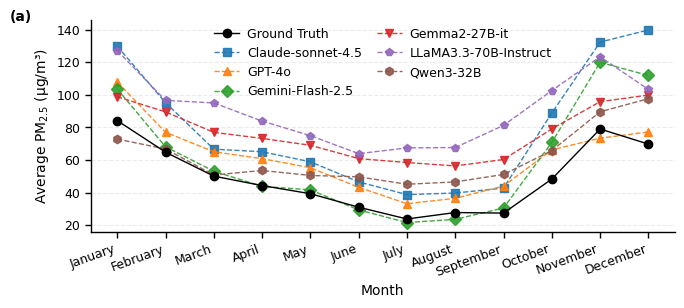

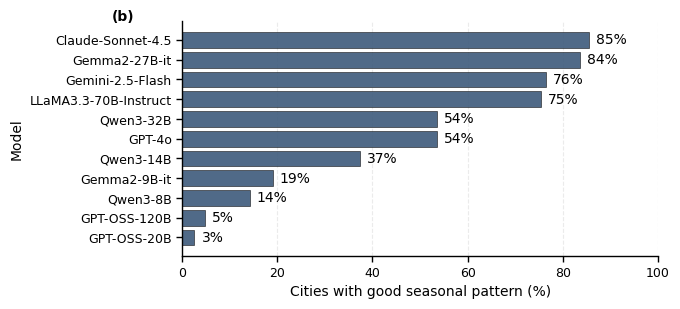

In [34]:
# ============================
# Figure 3a: Seasonal trends
# ============================
latexify(columns=2, fig_height=3.2)

fig, ax = plt.subplots(1, 1)  # no figsize here

month_order = [
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
]

gt_monthly = (
    ground_truth_df.groupby('month')['ground_truth_pm25']
    .mean()
    .reindex(month_order)
)

model_monthly = (
    merged_df.groupby(['model_name','month'])['pm2.5']
    .mean()
    .unstack(fill_value=np.nan)
    .reindex(columns=month_order)
)

x = np.arange(len(month_order))

# Ground truth
ax.plot(
    x, gt_monthly.values,
    color='black',
    marker='o',
    label='Ground Truth',
    zorder=3
)

colors  = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
markers = ['s','^','D','v','p','h']

for (model_name, row), col, mk in zip(model_monthly.iterrows(), colors, markers):
    ax.plot(
        x, row.values,
        color=col,
        linestyle='--',
        marker=mk,
        label=model_name,
        alpha=0.9,
        zorder=2
    )

ax.set_ylabel('Average PM$_{2.5}$ (µg/m³)')
ax.set_xlabel('Month')

ax.set_xticks(x)
ax.set_xticklabels(month_order, rotation=20, ha='right')

ax.grid(axis='y', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)

# Panel label
ax.text(
    -0.10, 1.05, '(a)',
    transform=ax.transAxes,
    fontweight='bold',
    va='top', ha='right'
)

ax.legend(
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    columnspacing=1.2,
    handletextpad=0.6
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('zero_shot_seasonality.pdf', bbox_inches='tight', format='pdf')
plt.show()

# ============================
# Figure 3b: Seasonal capture
# ============================
latexify(columns=2, fig_height=3.2)

fig, ax = plt.subplots(1, 1)

seasonal_df_sorted = seasonal_df.sort_values(
    "pct_cities_good", ascending=True
)

y = np.arange(len(seasonal_df_sorted))

bars = ax.barh(
    y,
    seasonal_df_sorted["pct_cities_good"],
    color="#3D5A7B",
    alpha=0.9,
    height=0.8,
    edgecolor='black',
    linewidth=0.4
)

ax.set_xlabel("Cities with good seasonal pattern (%)")
ax.set_ylabel("Model")

ax.set_yticks(y)
ax.set_yticklabels(seasonal_df_sorted["model"])

ax.set_xlim(0, 100)
ax.grid(axis="x", linestyle="--", alpha=0.25)
ax.set_axisbelow(True)

# Percentage labels
for bar, value in zip(bars, seasonal_df_sorted["pct_cities_good"]):
    ax.text(
        bar.get_width() + 1.5,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.0f}%",
        va="center",
        ha="left"
    )

# Panel label
ax.text(
    -0.10, 1.05, '(b)',
    transform=ax.transAxes,
    fontweight='bold',
    va='top', ha='right'
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('zero_shot_seasonality_city_count.pdf', bbox_inches='tight', format='pdf')
plt.show()


### With Non Zero temperature

In [3]:
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df['YearMonth'] = pd.to_datetime(gt_df['YearMonth'])
gt_df['year'] = gt_df['YearMonth'].dt.year
gt_df['month'] = gt_df['YearMonth'].dt.strftime('%B')

gt_df = gt_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df = gt_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [4]:
gt_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


In [4]:
gt_df['state'].nunique()

29

In [5]:
model_paths = {
    "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv"
}

In [6]:
def load_and_analyze(model_name, path):
    df = pd.read_csv(path)
    # Standardize column names
    df.columns = [col.lower().replace('pm2.5_', 'pm25_') for col in df.columns]
    pm25_cols = [col for col in df.columns if col.startswith('pm25_')]
    
    # Flatten all predictions to calculate global stats
    preds_flat = df[pm25_cols].values.flatten()
    preds_flat_series = pd.Series(preds_flat)
    
    total = len(preds_flat)
    invalid = ((preds_flat_series < 0) | (preds_flat_series > 500)).sum()
    invalid_pct = 100 * invalid / total
    
    # Calculate variance and std dev per city-month (row)
    df['pred_variance'] = df[pm25_cols].var(axis=1)
    df['pred_std'] = df[pm25_cols].std(axis=1)
    
    # Summarize variance/std dev across all city-months
    mean_variance = df['pred_variance'].mean()
    median_variance = df['pred_variance'].median()
    mean_std = df['pred_std'].mean()
    median_std = df['pred_std'].median()
    
    return {
        "Model": model_name,
        "Total Predictions": total,
        "Min": preds_flat_series.min(),
        "Max": preds_flat_series.max(),
        "% Invalid (<0 or >500)": round(invalid_pct, 3),
        "Mean": preds_flat_series.mean(),
        "Std Dev": preds_flat_series.std(),
        "Mean Variance (per city-month)": mean_variance,
        "Median Variance (per city-month)": median_variance,
        "Mean Std Dev (per city-month)": mean_std,
        "Median Std Dev (per city-month)": median_std
    }

# Analyze all models and collect results
results = []
for model_name, path in model_paths.items():
    res = load_and_analyze(model_name, path)
    results.append(res)

# Convert to DataFrame for display
rq1_1_df = pd.DataFrame(results)
rq1_1_df


,Model,Total Predictions,Min,Max,% Invalid (<0 or >500),Mean,Std Dev,Mean Variance (per city-month),Median Variance (per city-month),Mean Std Dev (per city-month),Median Std Dev (per city-month)
0,gemma2-9b-it,24120,4.5,325.0,0.0,52.983006,28.053469,333.922019,132.864500,15.054655,11.526686
1,gemma2-27b-it,24120,17.0,301.0,0.0,75.821882,32.158559,120.313981,87.155556,9.744531,9.335714
2,llama3-8b-Instruct,24120,2.0,151.0,0.0,24.542841,14.896274,113.933326,62.650000,8.466395,7.915170
3,llama3-70b-Instruct,24120,10.0,254.0,0.0,91.631509,48.335597,164.627474,29.566667,8.227205,5.437524
4,qwen3-32b,24120,14.5,420.5,0.0,61.588698,36.459884,373.713734,57.951556,13.248435,7.612574


In [7]:
gt_mean = gt_df["ground_truth_pm25"].mean()
gt_std = gt_df["ground_truth_pm25"].std()

print(f"Ground Truth Mean PM2.5: {gt_mean:.2f}")
print(f"Ground Truth Std Dev PM2.5: {gt_std:.2f}")

Ground Truth Mean PM2.5: 49.15
Ground Truth Std Dev PM2.5: 36.84


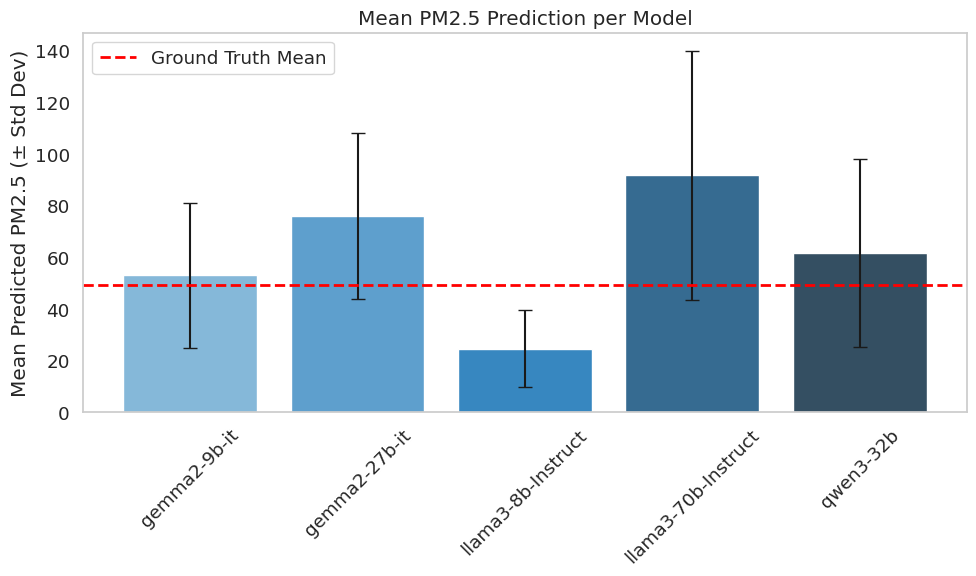

In [12]:
sns.set_theme(style="whitegrid", font_scale=1.2)

# Ground truth
gt_mean = 49.15

# Prepare data
models = rq1_1_df["Model"]
means = rq1_1_df["Mean"]
stds = rq1_1_df["Std Dev"]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, means, yerr=stds, capsize=5, color=sns.color_palette("Blues_d", n_colors=len(models)))

# Add Ground Truth Mean line
plt.axhline(gt_mean, color='red', linestyle='--', linewidth=2, label='Ground Truth Mean')

# Labels and title
plt.ylabel("Mean Predicted PM2.5 (± Std Dev)")
plt.title("Mean PM2.5 Prediction per Model")
plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_1859280/1323024309.py:28: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.violinplot(


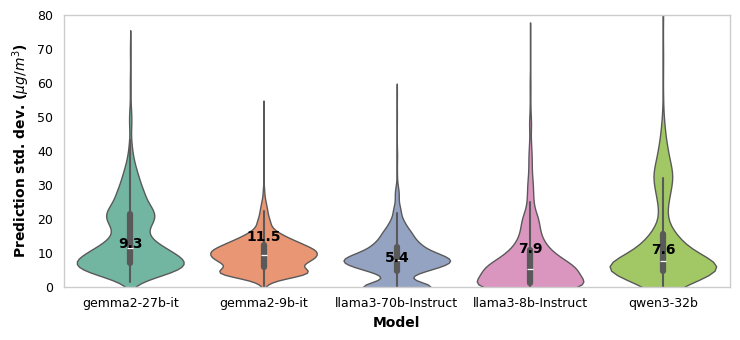

In [8]:
sns.set_theme(style="whitegrid")
latexify(columns=2,fig_width=7.5,fig_height=3.5)


# ---------- Load & prepare data ----------
all_data = []
for model in rq1_1_df["Model"]:
    df = pd.read_csv(model_paths[model])

    df.columns = [col.lower().replace("pm2.5_", "pm25_") for col in df.columns]
    pm25_cols = [col for col in df.columns if col.startswith("pm25_")]

    df["std_dev"] = df[pm25_cols].std(axis=1)

    all_data.append(
        pd.DataFrame({
            "Model": model,
            "StdDev": df["std_dev"].values,
        })
    )

combined_df = pd.concat(all_data, ignore_index=True)


# ---------- Violin plot ----------
fig, ax = plt.subplots()

sns.violinplot(
    data=combined_df,
    x="Model",
    y="StdDev",
    hue="Model",
    # palette="pastel",
    palette=sns.color_palette("Set2"),
    legend=False,
    ax=ax,
)

# ax.text(
#     -0.12, 1.05,
#     "(a)",
#     transform=ax.transAxes,
#     fontsize=12,
#     fontweight="bold",
#     va="top",
#     ha="left"
# )


ax.set_ylabel(r"Prediction std. dev. ($\mu g/m^3$)", fontweight="bold")
ax.set_xlabel("Model", fontweight="bold")

# ax.tick_params(axis="x")
# for tick in ax.get_xticklabels():
#     tick.set_ha("right")

# Median annotations
medians = combined_df.groupby("Model")["StdDev"].median()

ax.set_xticks(np.arange(len(medians)))
ax.set_xticklabels(medians.index)

for i, median_val in enumerate(medians):
    ax.text(
        i,
        median_val + 2,
        f"{median_val:.1f}",
        ha="center",
        color="black",
        fontweight="bold"
    )

ax.tick_params(axis="both", colors="black")
ax.yaxis.label.set_color("black")
ax.xaxis.label.set_color("black")

# Axis cleanup
ax.set_ylim(0, 80)
ax.grid(False)

fig.tight_layout()

fig.savefig(
    "prompt_stddev_violin.pdf",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


> With 0 temerature results

> Combined plot of KDE

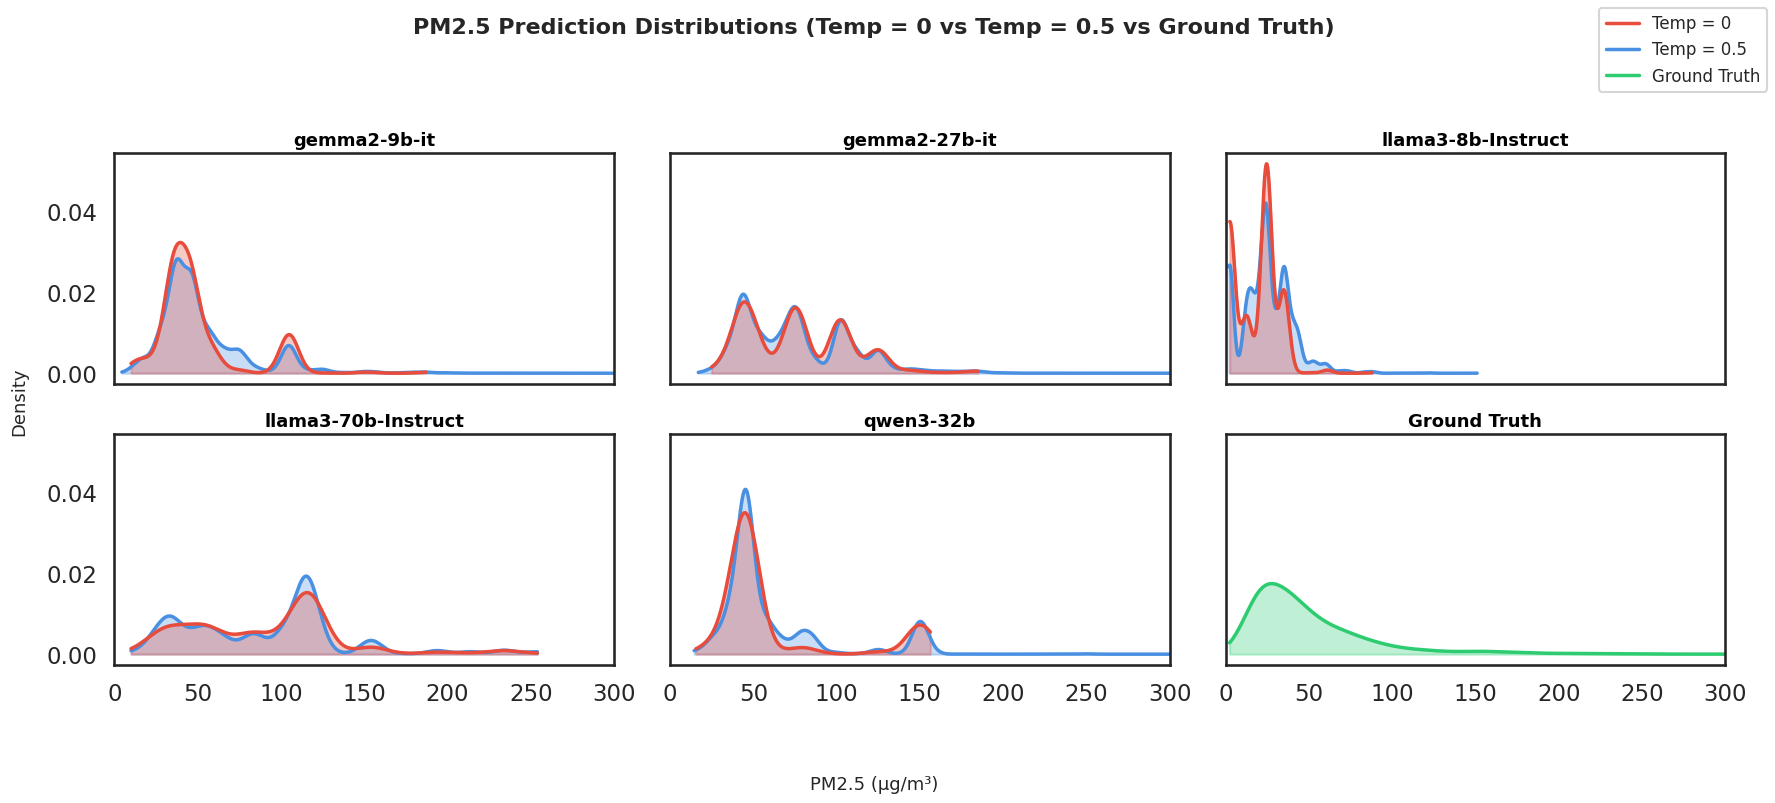

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# === File paths ===
with_temp_paths = {
    "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv"
}

zero_temp_paths = {
    "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv",
    "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv",
    "llama3-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv",
    "llama3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv",
    "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv"
}

# === Load Ground Truth ===
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df['YearMonth'] = pd.to_datetime(gt_df['YearMonth'])
gt_df['year'] = gt_df['YearMonth'].dt.year
gt_df['month'] = gt_df['YearMonth'].dt.strftime('%B')

gt_df = gt_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df = gt_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]
gt_values = gt_df["ground_truth_pm25"].dropna().values

# === Helper: KDE computation ===
def compute_kde(data):
    data = data[np.isfinite(data)]
    if len(data) < 2:
        return None
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), min(data.max(), 300), 1000)
    y_vals = kde(x_vals)
    return x_vals, y_vals

# === Plot settings ===
sns.set_context("talk")
sns.set_style("white")
model_list = list(with_temp_paths.keys())
colors = {"Temp = 0": "#E74C3C", "Temp = 0.5": "#4A90E2", "Ground Truth": "#2ECC71"}

# === Create subplots: 2 rows, 3 columns ===
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

# === Model-wise plots ===
for idx, model in enumerate(model_list):
    ax = axes[idx]

    # Load predictions for Temp = 0.5
    df_temp = pd.read_csv(with_temp_paths[model])
    df_temp.columns = [col.lower().replace("pm2.5_", "pm25_") for col in df_temp.columns]
    pm25_cols = [col for col in df_temp.columns if col.startswith("pm25_")]
    preds_temp = df_temp[pm25_cols].values.flatten()
    kde_temp = compute_kde(preds_temp)

    # Load predictions for Temp = 0
    df_zero = pd.read_csv(zero_temp_paths[model])
    preds_zero = df_zero["pm2.5"].dropna().values
    kde_zero = compute_kde(preds_zero)

    # Plot both KDEs
    if kde_temp is not None:
        x_temp, y_temp = kde_temp
        ax.fill_between(x_temp, y_temp, alpha=0.3, color=colors["Temp = 0.5"])
        ax.plot(x_temp, y_temp, color=colors["Temp = 0.5"], label="Temp = 0.5", linewidth=2.5)
    if kde_zero is not None:
        x_zero, y_zero = kde_zero
        ax.fill_between(x_zero, y_zero, alpha=0.3, color=colors["Temp = 0"])
        ax.plot(x_zero, y_zero, color=colors["Temp = 0"], label="Temp = 0", linewidth=2.5)

    ax.set_title(model, fontsize=13, weight='semibold', color='black')
    ax.set_xlim(0, 300)

# === Ground Truth in last subplot ===
ax = axes[-1]
kde_gt = compute_kde(gt_values)

if kde_gt is not None:
    x_gt, y_gt = kde_gt
    ax.fill_between(x_gt, y_gt, alpha=0.3, color=colors["Ground Truth"])
    ax.plot(x_gt, y_gt, color=colors["Ground Truth"], label="Ground Truth", linewidth=2.5)
    ax.set_title("Ground Truth", fontsize=13, weight='semibold', color='black')
    ax.set_xlim(0, 300)

# === Common labels and legend ===
fig.suptitle("PM2.5 Prediction Distributions (Temp = 0 vs Temp = 0.5 vs Ground Truth)", fontsize=16, weight="bold")
fig.supxlabel("PM2.5 (μg/m³)", fontsize=13)
fig.supylabel("Density", fontsize=13)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

# Legend once for the full figure
handles = [plt.Line2D([], [], color=color, lw=2.5, label=label) for label, color in colors.items()]
fig.legend(handles=handles, loc="upper right", fontsize=12)

plt.show()


In [20]:
# ---------- File paths ----------
with_temp_paths = {
    "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_9b_it_2023_With_Temp.csv",
    "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/gemma2_27b_it_2023_With_Temp.csv",
    "llama3-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_8b_it_2023_With_Temp.csv",
    "llama3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/llama3_70b_it_2023_With_Temp.csv",
    "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/With_Temperature/qwen3_32b_2023_With_Temp.csv",
}

zero_temp_paths = {
    "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv",
    "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv",
    "llama3-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv",
    "llama3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv",
    "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv",
}

# ---------- Ground truth ----------
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")
gt_df["YearMonth"] = pd.to_datetime(gt_df["YearMonth"])
gt_df["year"] = gt_df["YearMonth"].dt.year
gt_df["month"] = gt_df["YearMonth"].dt.strftime("%B")

gt_df = gt_df.rename(columns={"PM2.5": "ground_truth_pm25"})
gt_df = gt_df[["city", "state", "year", "month", "YearMonth", "ground_truth_pm25"]]
gt_values = gt_df["ground_truth_pm25"].dropna().values


# ---------- KDE helper ----------
def compute_kde(data):
    data = data[np.isfinite(data)]
    if len(data) < 2:
        return None
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), min(data.max(), 300), 1000)
    y_vals = kde(x_vals)
    return x_vals, y_vals


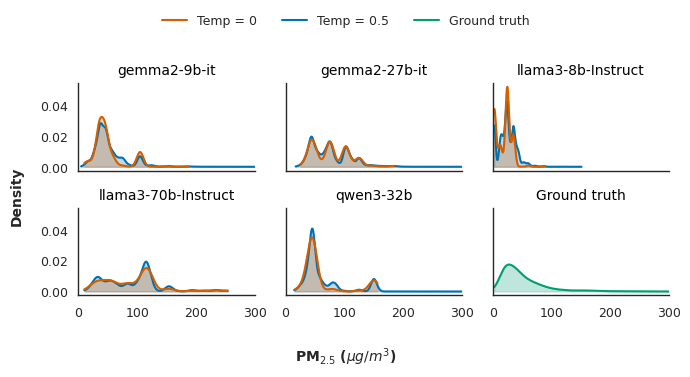

In [33]:
# ---------- Style: Seaborn + LaTeX ----------
sns.set_theme(style="white")
latexify(columns=2, fig_width=7.0, fig_height=3.5)

colors = {
    "Temp = 0": "#D55E00",       # orange
    "Temp = 0.5": "#0072B2",     # blue
    "Ground Truth": "#009E73",   # green
}

model_list = list(with_temp_paths.keys())

# ---------- Subplots ----------
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
axes = axes.flatten()

x_min, x_max = 0, 300

# axes[0].text(
#     -0.3, 1.15,
#     "(b)",
#     transform=axes[0].transAxes,
#     fontsize=12,
#     fontweight="bold",
#     va="top",
#     ha="left"
# )

# ---------- Model-wise KDE plots ----------
for idx, model in enumerate(model_list):
    ax = axes[idx]

    # Temp = 0.5
    df_temp = pd.read_csv(with_temp_paths[model])
    df_temp.columns = [col.lower().replace("pm2.5_", "pm25_") for col in df_temp.columns]
    pm25_cols = [col for col in df_temp.columns if col.startswith("pm25_")]
    preds_temp = df_temp[pm25_cols].values.flatten()
    kde_temp = compute_kde(preds_temp)

    # Temp = 0
    df_zero = pd.read_csv(zero_temp_paths[model])
    preds_zero = df_zero["pm2.5"].dropna().values
    kde_zero = compute_kde(preds_zero)

    if kde_temp is not None:
        x_temp, y_temp = kde_temp
        ax.fill_between(x_temp, y_temp, alpha=0.25, color=colors["Temp = 0.5"])
        ax.plot(x_temp, y_temp, color=colors["Temp = 0.5"],
                label="Temp = 0.5", linewidth=1.5)

    if kde_zero is not None:
        x_zero, y_zero = kde_zero
        ax.fill_between(x_zero, y_zero, alpha=0.25, color=colors["Temp = 0"])
        ax.plot(x_zero, y_zero, color=colors["Temp = 0"],
                label="Temp = 0", linewidth=1.5)

    # model name ABOVE plot (title), normal weight
    ax.set_title(model, fontsize=10, fontweight="normal", color="black")

    ax.set_xlim(x_min, x_max)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# ---------- Ground truth in last panel ----------
ax_gt = axes[-1]
kde_gt = compute_kde(gt_values)

if kde_gt is not None:
    x_gt, y_gt = kde_gt
    ax_gt.fill_between(x_gt, y_gt, alpha=0.25, color=colors["Ground Truth"])
    ax_gt.plot(x_gt, y_gt, color=colors["Ground Truth"],
               label="Ground truth", linewidth=1.5)
    ax_gt.set_xlim(x_min, x_max)

ax_gt.set_title("Ground truth", fontsize=10, fontweight="normal", color="black")
ax_gt.spines["top"].set_visible(False)
ax_gt.spines["right"].set_visible(False)

# ---------- Common labels ----------
fig.supxlabel(r"PM$_{2.5}$ ($\mu g/m^3$)", fontsize=10, fontweight="bold")
fig.supylabel("Density", fontsize=10, fontweight="bold")

# ---------- Legend ----------
handles = [
    plt.Line2D([], [], color=colors["Temp = 0"], lw=1.5, label="Temp = 0"),
    plt.Line2D([], [], color=colors["Temp = 0.5"], lw=1.5, label="Temp = 0.5"),
    plt.Line2D([], [], color=colors["Ground Truth"], lw=1.5, label="Ground truth"),
]
fig.legend(
    handles=handles,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),
)

fig.tight_layout(rect=[0, 0, 1, 0.92])

fig.savefig("kde_temp_effects.pdf", dpi=300, bbox_inches="tight")
plt.show()


### Ablation study on prompt

In [12]:
ground_truth_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/CitySubset_GroundTruth.csv")

ground_truth_df['YearMonth'] = pd.to_datetime(ground_truth_df['YearMonth'])
ground_truth_df['year'] = ground_truth_df['YearMonth'].dt.year
ground_truth_df['month'] = ground_truth_df['YearMonth'].dt.strftime('%B')

ground_truth_df = ground_truth_df.rename(columns={'PM2.5': 'ground_truth_pm25'})

ground_truth_df = ground_truth_df[['city', 'state', 'year', 'month', 'YearMonth', 'ground_truth_pm25']]

In [10]:
ground_truth_df.head()

,city,state,year,month,YearMonth,ground_truth_pm25
0,Agartala,Tripura,2023,January,2023-01-01,196.040103
1,Agartala,Tripura,2023,February,2023-02-01,170.874875
2,Agartala,Tripura,2023,March,2023-03-01,119.490881
3,Agartala,Tripura,2023,April,2023-04-01,94.205356
4,Agartala,Tripura,2023,May,2023-05-01,63.553585


In [4]:
gemma_9b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
llama_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
llama1_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_1_70b_it_2023_predictions.csv")
qwen_32b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
print(gemma_9b_df.columns)

Index(['city', 'state', 'year', 'month', 'model', 'pm2.5'], dtype='object')


In [7]:
gemma_9b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/gemma2_9b_it_2023.csv")
gemma_27b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/gemma2_27b_it_2023.csv")
llama_8b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/llama3_8b_it_2023.csv")
llama_70b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/llama3_70b_it_2023.csv")
llama1_70b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/llama3_1_70b_it_2023.csv")
qwen_32b_pv1_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/qwen3_32b_2023.csv")

In [8]:
gemma_9b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/gemma2_9b_it_2023.csv")
gemma_27b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/gemma2_27b_it_2023.csv")
llama_8b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/llama3_8b_it_2023.csv")
llama_70b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/llama3_70b_it_2023.csv")
llama1_70b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/llama3_1_70b_it_2023.csv")
qwen_32b_pv2_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/qwen3_32b_2023.csv")

In [9]:
gemma_9b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/gemma2_9b_it_2023.csv")
gemma_27b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/gemma2_27b_it_2023.csv")
llama_8b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/llama3_8b_it_2023.csv")
llama_70b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/llama3_70b_it_2023.csv")
llama1_70b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/llama3_1_70b_it_2023.csv")
qwen_32b_pv3_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/qwen3_32b_2023.csv")

In [32]:
merge_cols = ["city", "state", "year", "month"]

# === Define correct model names and prompt variants ===
prompt_variants = {
    "original": {
        "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv",
        "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv",
        "llama3.1-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv",
        "llama3.3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv",
        "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv"
    },
    "pv1": {
        "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/llama3_70b_it_2023.csv",
        "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV1/qwen3_32b_2023.csv"
    },
    "pv2": {
        "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/llama3_70b_it_2023.csv",
        "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV2/qwen3_32b_2023.csv"
    },
    "pv3": {
        "gemma2-9b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/gemma2_9b_it_2023.csv",
        "gemma2-27b-it": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/gemma2_27b_it_2023.csv",
        "llama3.1-8b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/llama3_8b_it_2023.csv",
        "llama3.3-70b-Instruct": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/llama3_70b_it_2023.csv",
        "qwen3-32b": "/home/diya.thakor/AirQuality/RQ1/Dataset/PV3/qwen3_32b_2023.csv"
    }
}

# === Compute metrics ===
results = []

for variant, model_paths in prompt_variants.items():
    for model, path in model_paths.items():
        df = pd.read_csv(path)
        merged = pd.merge(df, ground_truth_df, on=merge_cols, how="inner")
        merged = merged.dropna(subset=["pm2.5", "ground_truth_pm25"])

        if len(merged) == 0:
            mae = np.nan
            corr = np.nan
            over_pct = np.nan
            under_pct = np.nan
            out_of_range = np.nan
            below_zero = np.nan
            above_500 = np.nan
        else:
            mae = np.mean(np.abs(merged["pm2.5"] - merged["ground_truth_pm25"]))
            corr = np.corrcoef(merged["pm2.5"], merged["ground_truth_pm25"])[0, 1] if len(merged) > 1 else np.nan
            over_pct = (merged["pm2.5"] > merged["ground_truth_pm25"]).mean() * 100
            under_pct = (merged["pm2.5"] < merged["ground_truth_pm25"]).mean() * 100

            # Range check
            below_zero = (merged["pm2.5"] < 0).sum()
            above_500 = (merged["pm2.5"] > 500).sum()
            out_of_range = below_zero + above_500
            total_preds = len(merged)

        results.append({
            "Prompt_Variant": variant,
            "Model": model,
            "MAE": round(mae, 2),
            "Correlation": round(corr, 3),
            "Over (%)": round(over_pct, 1),
            "Under (%)": round(under_pct, 1),
            "Out-of-Range Count": out_of_range,
            "Below 0": below_zero,
            "Above 500": above_500,
            "Total Predictions": total_preds,
            "% Invalid": round(100 * out_of_range / total_preds, 3) if total_preds > 0 else np.nan
        })

# === Final DataFrame ===
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "Prompt_Variant"]).reset_index(drop=True)
results_df


,Prompt_Variant,Model,MAE,Correlation,Over (%),Under (%),Out-of-Range Count,Below 0,Above 500,Total Predictions,% Invalid
0,original,gemma2-27b-it,29.55,0.634,84.7,15.3,0,0,0,660,0.0
1,pv1,gemma2-27b-it,30.52,0.622,85.8,14.2,0,0,0,660,0.0
2,pv2,gemma2-27b-it,25.22,0.605,78.3,21.7,0,0,0,660,0.0
3,pv3,gemma2-27b-it,22.79,0.613,75.9,24.1,0,0,0,660,0.0
4,original,gemma2-9b-it,23.94,0.339,57.5,42.5,0,0,0,654,0.0
5,pv1,gemma2-9b-it,22.39,0.383,54.7,45.3,0,0,0,660,0.0
6,pv2,gemma2-9b-it,27.98,0.155,50.6,49.4,0,0,0,660,0.0
7,pv3,gemma2-9b-it,31.08,0.171,48.9,51.1,0,0,0,660,0.0
8,original,llama3.1-8b-Instruct,35.12,0.283,8.9,91.1,0,0,0,282,0.0
9,pv1,llama3.1-8b-Instruct,23.93,0.164,48.3,51.7,0,0,0,652,0.0


In [62]:
# First, reshape to have Prompt_Variant as columns and MAE as values
mae_df = results_df.pivot(index="Model", columns="Prompt_Variant", values="MAE").reset_index()

# Optional: Reorder the prompt variants
variant_order = ["original", "pv1", "pv2", "pv3"]
mae_df = mae_df[["Model"] + variant_order]

# Round to 2 decimal places
mae_df = mae_df.round(2)

# Compute mean MAE for each prompt variant and append as a row
mean_row = mae_df[variant_order].mean().round(2)
mean_row["Model"] = "Mean"
mae_df = pd.concat([mae_df, pd.DataFrame([mean_row])], ignore_index=True)

print(mae_df)


Prompt_Variant                  Model  original    pv1    pv2    pv3
0                       gemma2-27b-it     29.55  30.52  25.22  22.79
1                        gemma2-9b-it     23.94  22.39  27.98  31.08
2                llama3.1-8b-Instruct     35.12  23.93  30.94  25.80
3               llama3.3-70b-Instruct     39.05  38.32  42.12  46.63
4                           qwen3-32b     24.88  30.15  23.44  26.70
5                                Mean     30.51  29.06  29.94  30.60
